In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import os
import matplotlib.dates as mdates

colors = ['r','r','g','g','b','b']
lines = ['--','-','--','-','--','-']
Zones = ['Low','Mid','High']
Irrigs = ['STD','VRI']

## Get Layout file

In [2]:
Layout = pd.read_excel('K:\CPDiary\Data\BaxtersMVI\TrialLayout.xlsx',index_col='Plot')

## Get the Neutron probe and TDR data

In [3]:
NPFiles = []
TDRFiles = []
mydir = 'K:\CPDiary\Data\BaxtersMVI\Soil moisture data'
for file in os.listdir(mydir):
    if file.endswith('.NP1'):
        NPFiles.append(os.path.join(mydir, file))
    if file.endswith('.NP2'):
        NPFiles.append(os.path.join(mydir, file))
    if file.endswith('.TDR'):
        TDRFiles.append(os.path.join(mydir, file))

## Get all set up with indexing for experiment

In [4]:
#Set up blank dataframe to take data
ColumnLables = ['Plot','Date','D7','D6','D5','D4','D3','D2','D1']
TabIndex = pd.MultiIndex.from_arrays([[],[]],names=['Plot','Date'])
SoilWaterData = pd.DataFrame(columns=ColumnLables[2:],index = TabIndex)
#Read each file
for ObsTable in NPFiles:
    #Read in file and find which lines have legit data
    HeaderRowsToSkip = 29
    DataTab = pd.read_csv(ObsTable,skiprows = range(HeaderRowsToSkip),header=None,delim_whitespace=True)
    DataTab.dropna(inplace=True)
    DataTab.drop([0,1,3,5],axis=1,inplace=True)
    DataTab.columns = ColumnLables
    DataTab.ix[:,1] = pd.to_datetime(DataTab.ix[:,1],format='%m/%d/%y')
    SoilWaterData = SoilWaterData.append(DataTab)
SoilWaterData.ix[:,'Plot'] = np.int64(SoilWaterData.ix[:,'Plot'] )
SoilWaterData = SoilWaterData.where(SoilWaterData.ix[:,'Plot']<25).dropna()
SoilWaterData.ix[:,'Zone'] = [Layout.ix[int(x),'Zone'] for x in SoilWaterData.Plot]
SoilWaterData.ix[:,'Irrig'] = [Layout.ix[int(x),'Irrig'] for x in SoilWaterData.Plot]
SoilWaterData.ix[:,'Rep'] = [Layout.ix[int(x),'Rep'] for x in SoilWaterData.Plot]
SoilWaterData.set_index(['Plot','Date'],inplace=True,drop=False)

#Add in the TDR Data
SoilWaterData.ix[:,'D0'] = np.nan
for TDRTable in TDRFiles:
    TDRData = pd.read_csv(TDRTable,header=None).ix[:,[2,11,3]]
    TDRData.columns = ['Plot','Date','D0']
    TDRData = TDRData.drop_duplicates(subset=['Plot','Date'])
    TDRData.ix[:,'Date'] = pd.to_datetime(TDRData.ix[:,'Date'], format = '%d%b%Y')
    TDRData.set_index(['Plot','Date'],inplace=True)
    SoilWaterData.update(TDRData)
    
ObsDates = list(SoilWaterData.index.levels[1])

## Determine drained upper limit

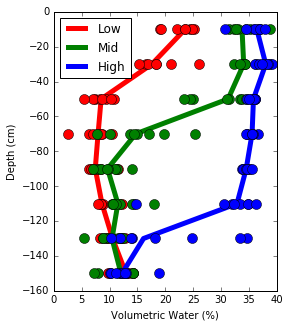

In [5]:
DUL = SoilWaterData.ix[SoilWaterData.Date=='2017-10-04',:].copy()
DUL.index = DUL.index.droplevel(1)
DULGraph, ax = plt.subplots(figsize = (4,5))
pos = 0
cols = ['r','g','b']
for ZoneID in ['Low','Mid','High']:
    ZoneFC = DUL.ix[DUL.Zone==ZoneID,['D0','D1','D2','D3','D4','D5','D6','D7']]
    Mean = ZoneFC.median()
    plt.plot(Mean,[-10,-30,-50,-70,-90,-110,-130,-150],lw=5,color=cols[pos],label = ZoneID)
    for plot in ZoneFC.index:
        plt.plot(ZoneFC.ix[plot].values,[-10,-30,-50,-70,-90,-110,-130,-150],'o', color = cols[pos],ms=10)
    pos += 1
plt.ylabel('Depth (cm)')
plt.xlabel('Volumetric Water (%)')
plt.legend(loc=2)

## Determine other soil parameters for all plots and depths

In [6]:
#Calculate Saturated water content for top soil (soil_layer = 1) and sub soils (all other layers)
#DUL must be input as mm3/mm3
def Est_SAT_from_DUL(DUL, soil_layer):
    if soil_layer <= 2:
        break_point = 30
        slope1 = 0.35
        Intercept1 = 30
        slope2 = 0.7
        Intercept2 = (Intercept1 + break_point * slope1) - (break_point * slope2)
    else: 
        break_point = 25
        slope1 = 0.07
        Intercept1 = 30
        slope2 = 0.8
        Intercept2 = (Intercept1 + break_point * slope1) - (break_point * slope2)

    if DUL <= break_point:
        Est_SAT = Intercept1 + DUL * slope1
    else:
        Est_SAT = Intercept2 + DUL * slope2
    return Est_SAT

#Calculate Saturated water content for top soil (soil_layer = 1) and sub soils (all other layers)
def Est_LL_from_DUL(DUL, soil_layer):
    DUL_vol = DUL
    if soil_layer <= 2:
        break_point = 25
        slope1 = 0.2522
        Intercept1 = 0 
        slope2 = 0.835
        Intercept2 = (Intercept1 + break_point * slope1) - (break_point * slope2)
    else: 
        break_point = 25
        slope1 = 0.5
        Intercept1 = 0
        slope2 = 0.8
        Intercept2 = (Intercept1 + break_point * slope1) - (break_point * slope2)

    if DUL_vol <= break_point:
        Estimate_LL_vol = Intercept1 + DUL_vol * slope1
    else:
        Estimate_LL_vol = Intercept2 + DUL_vol * slope2
    return Estimate_LL_vol

# Set up dataFrames for other parameters
LL = DUL.copy()#pd.DataFrame(index = DUL.index, columns = DUL.columns)
LL.ix[:,['D1','D2','D3','D4','D5','D6','D7']]=0
SAT = DUL.copy()#pd.DataFrame(index = DUL.index, columns = DUL.columns)
SAT.ix[:,['D1','D2','D3','D4','D5','D6','D7']]=0
TP = DUL.copy()#pd.DataFrame(index = DUL.index, columns = DUL.columns)
TP.ix[:,['D1','D2','D3','D4','D5','D6','D7']]=0
RT = DUL.copy()#pd.DataFrame(index = DUL.index, columns = DUL.columns)
RT.ix[:,['D1','D2','D3','D4','D5','D6','D7']]=0

#Calculate parameter values for each depth
for plot in DUL.index:
    li = 0
    for l in ['D0','D1','D2','D3','D4','D5','D6','D7']:
        LL.loc[plot,l] = Est_LL_from_DUL(DUL.loc[plot,l],li)
        SAT.loc[plot,l] = Est_SAT_from_DUL(DUL.loc[plot,l],li)
        TP.loc[plot,l] = LL.loc[plot,l] + (DUL.loc[plot,l]-LL.loc[plot,l]) * 0.5
        RT.loc[plot,l] = LL.loc[plot,l] + (DUL.loc[plot,l]-LL.loc[plot,l]) * 0.9
        li +=1

### Calclculate soil profile parameters for each treatment

In [7]:
TreatIndex = pd.MultiIndex.from_product([['Low','Mid','High'],['STD','VRI']])
ProfileParams = pd.DataFrame(index = ['SAT','DUL','RT','TP','LL'],columns=TreatIndex)
Params80 = pd.DataFrame(index = ['SAT','DUL','RT','TP','LL'],columns=TreatIndex)
#All params multiplied by 2 to convert from % to mm
for treat in ProfileParams.columns:
    Filt = (SAT.Zone == treat[0]) & (SAT.Irrig == treat[1])
    ProfileParams.ix['SAT',treat] = SAT.ix[Filt,['D0','D1','D2','D3','D4','D5','D6','D7']].mean().sum() * 2
    Params80.ix['SAT',treat] = SAT.ix[Filt,['D0','D1','D2','D3']].mean().sum() * 2
    ProfileParams.ix['DUL',treat] = DUL.ix[Filt,['D0','D1','D2','D3','D4','D5','D6','D7']].mean().sum() * 2
    Params80.ix['DUL',treat] = DUL.ix[Filt,['D0','D1','D2','D3']].mean().sum() * 2
    ProfileParams.ix['RT',treat] = RT.ix[Filt,['D0','D1','D2','D3','D4','D5','D6','D7']].mean().sum() * 2
    Params80.ix['RT',treat] = RT.ix[Filt,['D0','D1','D2','D3']].mean().sum() * 2
    ProfileParams.ix['TP',treat] = TP.ix[Filt,['D0','D1','D2','D3','D4','D5','D6','D7']].mean().sum() * 2
    Params80.ix['TP',treat] = TP.ix[Filt,['D0','D1','D2','D3']].mean().sum() * 2
    ProfileParams.ix['LL',treat] = LL.ix[Filt,['D0','D1','D2','D3','D4','D5','D6','D7']].mean().sum() * 2
    Params80.ix['LL',treat] = LL.ix[Filt,['D0','D1','D2','D3']].mean().sum() * 2
    Params80.ix['IrrigCapacity',treat] = Params80.ix['RT',treat] - Params80.ix['TP',treat]

<function matplotlib.pyplot.tight_layout>

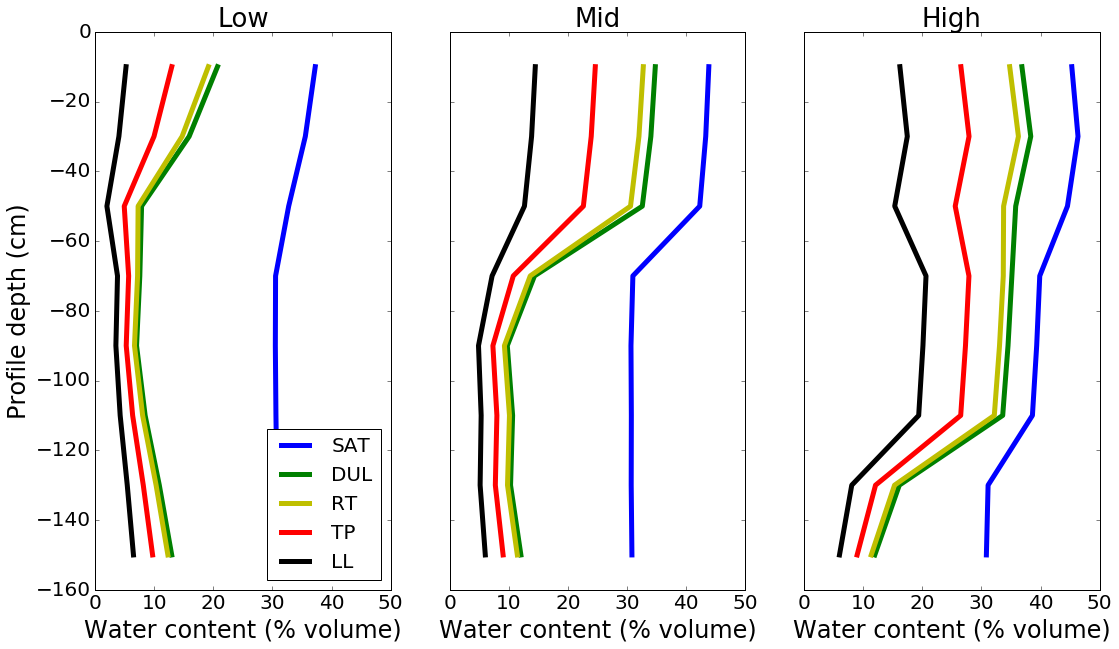

In [8]:
ProfileGraphs = plt.figure(figsize=(18,10))
axes = []
PlotPos = 1
for ZoneID in ['Low','Mid','High']:
    axes.append(ProfileGraphs.add_subplot(1,3,PlotPos))
    pos = 0
    cols = ['b','g','y','r','k']
    labs = ['SAT','DUL','RT','TP','LL']
    yloc = [-130,-140,-150]
    for Data in [SAT,DUL,RT,TP,LL]:
        Filter = (Data.Zone == ZoneID) & (Data.Irrig == 'STD')
        ParamWC = Data.ix[Filter,['D0','D1','D2','D3','D4','D5','D6','D7']]
        TreatMean = ParamWC.median()
        plt.plot(TreatMean,[-10,-30,-50,-70,-90,-110,-130,-150],'-',color=cols[pos],lw=5,label=labs[pos])
        plt.title(ZoneID,fontsize=26)
        pos +=1
    if PlotPos in [2,3]:
        axes[PlotPos-1].tick_params(labelleft='off') 
    if PlotPos ==1:
        plt.ylabel('Profile depth (cm)',fontsize=24)
        plt.legend(loc=4,fontsize=20)
    plt.xlabel('Water content (% volume)',fontsize=24)
    plt.tick_params(labelsize=20)
    plt.xlim(0,50)
    PlotPos += 1
    
plt.tight_layout 

<function matplotlib.pyplot.tight_layout>

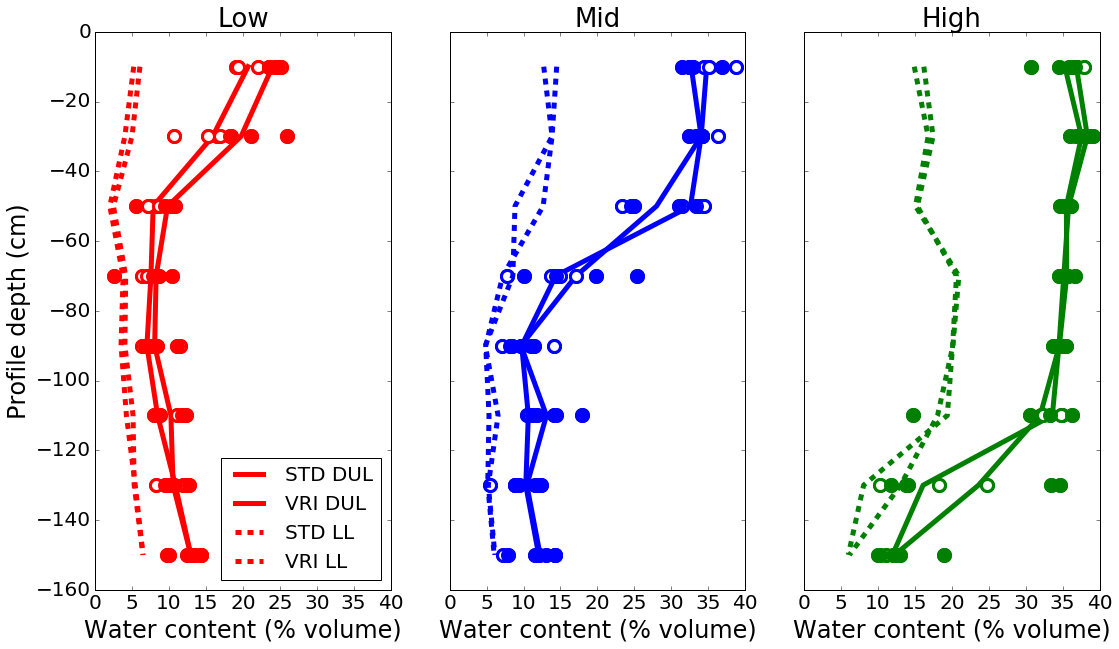

In [25]:
ProfileGraphs = plt.figure(figsize=(18,10))
axes = []
PlotPos = 1
Zcols = ['r','b','g']
for ZoneID in ['Low','Mid','High']:
    axes.append(ProfileGraphs.add_subplot(1,3,PlotPos))
    cols = ['cyan','k']
    labs = ['DUL','LL']
    lines = ['-','--']
    yloc = [-130,-140,-150]
    lpos = 0
    for Data in [DUL,LL]:
        pos = 0
        for I in Irrigs:
            Filter = (Data.Zone == ZoneID) & (Data.Irrig == I)
            ParamWC = Data.ix[Filter,['D0','D1','D2','D3','D4','D5','D6','D7']]
            TreatMean = ParamWC.median()
            plt.plot(TreatMean,[-10,-30,-50,-70,-90,-110,-130,-150],lines[lpos],color=Zcols[PlotPos-1],lw=5,label=I + ' ' + labs[lpos])
            plt.title(ZoneID,fontsize=26)
            ZoneFC = DUL.ix[DUL.Zone==ZoneID,['D0','D1','D2','D3','D4','D5','D6','D7']]
            for plot in ZoneFC.index:
                if Data.ix[plot,'Irrig'] == I:
                    if I == 'STD':
                        fillC = 'W'
                    else:
                        fillC = Zcols[PlotPos-1]
                    plt.plot(ZoneFC.ix[plot].values,[-10,-30,-50,-70,-90,-110,-130,-150],'o', mec = Zcols[PlotPos-1],mfc = fillC,ms=12,mew=3)
            pos += 1
        lpos+=1
    if PlotPos in [2,3]:
        axes[PlotPos-1].tick_params(labelleft='off') 
    if PlotPos ==1:
        plt.ylabel('Profile depth (cm)',fontsize=24)
        plt.legend(loc=4,fontsize=20)
    plt.xlabel('Water content (% volume)',fontsize=24)
    plt.tick_params(labelsize=20)
    plt.xlim(0,40)
    PlotPos += 1
    
plt.tight_layout 

In [10]:
Params = ['SAT','DUL','RT','TP','LL']
for dep in SoilWaterData.sort_index(axis=1).columns[:8]:
    for Param in Params:
        ParamAndDep = Param+'_'+dep
        SoilWaterData.ix[:,ParamAndDep] = np.nan
        CurrentParam = globals()[Param]
        for plot in range(1,25):
            SoilWaterData.ix[plot,ParamAndDep] = CurrentParam.ix[plot,dep]

### Get data into a excel useful format and export

In [11]:
SoilWaterData.sort_index(axis=1,inplace=True)
SoilWaterData.set_index(['Zone','Irrig','Rep','Date','Plot'],inplace=True)
SoilWaterData.sort_index(inplace=True)
SoilWaterData.ix[:,'ProfileWater'] = [np.sum(SoilWaterData.ix[x,:][['D0','D1','D2','D3','D4','D5','D6','D7']])*2 for x in SoilWaterData.index]
SoilWaterData.ix[:,'RootZoneWater'] = [np.sum(SoilWaterData.ix[x,:][['D0','D1','D2','D3','D4','D5']])*2 for x in SoilWaterData.index]
#SoilWaterData.to_excel('K:\CPDiary\Data\BaxtersMVI\SoilWaterRawData.xlsx',merge_cells=False,sheet_name='RawData')

## Set up the irrigaiton and rainfall data frame

In [12]:
#Set up a data frame and put the irrigation data in manually
ColIndex = pd.MultiIndex.from_product([('Low','Mid','High'),('STD','VRI')])
DateIndex = SoilWaterData.index.get_level_values(3).drop_duplicates()
Irrigations = pd.DataFrame(index=DateIndex,columns=ColIndex)
Irrigations.ix[:,:] = 0
Irrigations.ix['2017-10-25',:] = [0,0,0,0,0,0]
Irrigations.ix['2017-11-01',:] = [12.0,12.0,12.0,12.0,12.0,12.0]
Irrigations.ix['2017-11-08',:] = [56.1,27,56.1,37,56.1,37]
Irrigations.ix['2017-11-15',:] = [36.3,28,36.3,25.8,36.3,25.8]
Irrigations.ix['2017-11-22',:] = [30.6,25.1,30.6,27.1,30.6,28.1]
Irrigations.ix['2017-11-29',:] = [31.5,32,31.5,30,31.5,33]
Irrigations.ix['2017-12-06',:] = [41.8,30.3,41.8,40.3,41.8,43.3]
Irrigations.ix['2017-12-13',:] = [45.9,29,45.9,38,45.9,41]

#Bring in the rainfall data sum it over measurement periods and add into irrigation dataframe
Irrigations.ix[:,('Field','Rain')] = 0
DailyRain = pd.read_pickle('Rainfall.pkl')
PrevMeasureDate = ''
for P in Irrigations.index:
    if P.strftime('%Y-%m-%d') == '2017-10-04':
        PrevMeasureDate = '2017-10-04'
    else:
        YesterdayDate = (P - dt.timedelta(1)).strftime('%Y-%m-%d')
        Irrigations.ix[P.strftime('%Y-%m-%d'),('Field','Rain')] = DailyRain.ix[PrevMeasureDate:YesterdayDate].sum().values[0]
        PrevMeasureDate = P.strftime('%Y-%m-%d')

# Calculate Water use from water balance

In [13]:
ColIndex = pd.MultiIndex.from_product([('Low','Mid','High'),('STD','VRI'),(1,2,3,4)],names=['Zone','Irrig','Rep'])
WaterUseNP = pd.DataFrame(index = Irrigations.index,
    columns = ColIndex)
WaterUseNP.ix[:,:]=0
DeltaSWCFrame = WaterUseNP.copy()
IrrigationFrame = WaterUseNP.copy()
RainFallFrame = WaterUseNP.copy()
for plot in WaterUseNP.columns:
    for P in WaterUseNP.index:
        if P.strftime('%Y-%m-%d') == '2017-10-04':
            PrevPSWC = SoilWaterData.ix[(plot)].ix[P.strftime('%Y-%m-%d'),'ProfileWater'].values[0]
            PrevMeasureDate = '2017-10-04'
        else:
            #print(P.strftime('%Y-%m-%d'))
            DeltaSWC = PrevPSWC - SoilWaterData.ix[(plot)].ix[P.strftime('%Y-%m-%d'),'ProfileWater'].values[0]
            #print(DeltaSWC)
            DeltaSWCFrame.ix[P.strftime('%Y-%m-%d'),plot] = DeltaSWC
            Irrigation = Irrigations.ix[PrevMeasureDate,(plot[0],plot[1])]
            IrrigationFrame.ix[P.strftime('%Y-%m-%d'),plot] = Irrigation
            #print(Irrigation)
            Rainfall = Irrigations.ix[P.strftime('%Y-%m-%d'),('Field','Rain')]
            RainFallFrame.ix[P.strftime('%Y-%m-%d'),plot] = Rainfall
            #print(Rainfall)
            WU = DeltaSWC + Irrigation + Rainfall 
            #print(WU)
            WaterUseNP.ix[P.strftime('%Y-%m-%d'),plot] = WU
            PrevPSWC = SoilWaterData.ix[(plot)].ix[P.strftime('%Y-%m-%d'),'ProfileWater'].values[0]
            PrevMeasureDate = P.strftime('%Y-%m-%d')

#Days when irrigation needs to be considered in NP water balance calculations
IrrigationsDaysNP = ['2017-11-02','2017-11-09','2017-11-16','2017-11-23',
                   '2017-11-30','2017-12-07','2017-12-14',]

#Remove days when irrigatin was applied
#WaterUseNP.ix[WaterUseNP.index.isin(IrrigationsDaysNP)] = np.nan
#WaterUseNP.dropna(how='all',inplace=True)

C:\Anaconda\lib\site-packages\pandas\indexes\base.py:1256: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return getitem(key)


## Bring in the Water use estimations from IRs

In [14]:
#Days when irrigation occured
IrrigationsDaysIR = ['2017-11-01','2017-11-08','2017-11-15','2017-11-22',
                   '2017-11-29','2017-12-06','2017-12-13',]


#Read in the E data calculated from IR sensors
E = pd.read_pickle('Evaporation.pkl')

#Remove errant values
E.ix['2017-11-9':'2017-11-15',('Low','STD',4)] = E.ix['2017-11-9':'2017-11-15',('Low','STD')].ix[:,1:3].mean(axis=1)
E.ix[:,('Low','VRI',4)] = np.nan

#Remove days when irrigatin was applied
#E.ix[E.index.isin(IrrigationsDaysIR),:] = np.nan
#E.dropna(how='all',inplace=True)

C:\Anaconda\lib\site-packages\ipykernel\zmqshell.py:537: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:76: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


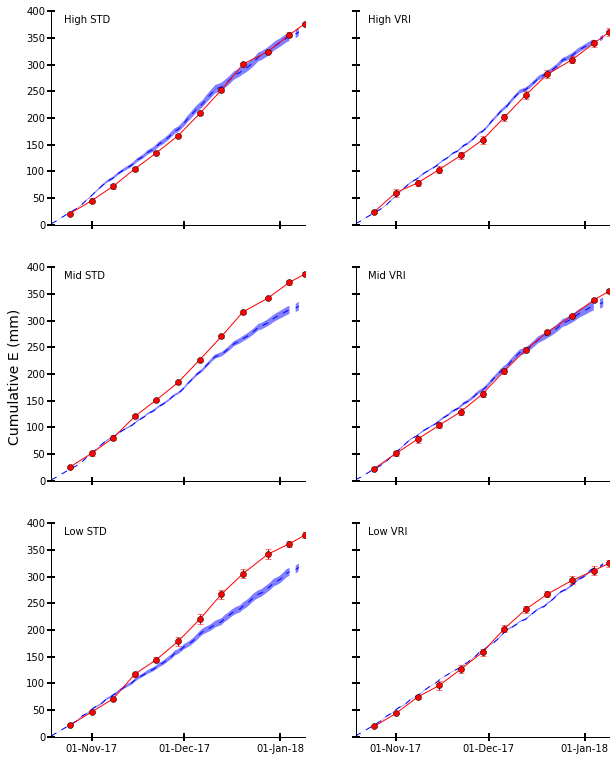

In [15]:
ObsPreIndex = pd.MultiIndex.from_product([['Obs','Pred'],['High','Mid','Low'],['STD','VRI']])
ObsPre = pd.DataFrame(index = E.index,columns = ObsPreIndex)
Fig = plt.figure(figsize=(10,13))
pos = 1
for z in ['High','Mid','Low']:
    for i in Irrigs:
        ax = Fig.add_subplot(3,2,pos)
        IRMean = E.ix[:,(z,i)].cumsum().mean(axis=1)
        ObsPre.ix[:,('Pred',z,i)] = IRMean
        IRSD = E.ix[:,(z,i)].cumsum().std(axis=1)/2
        IRUp = IRMean + IRSD
        IRLow = IRMean - IRSD
        plt.fill_between(E.index,IRUp,IRLow,alpha=0.5,lw=0)
        plt.plot(IRMean,'--')
        NPMean = WaterUseNP.ix['2017-10-20':,(z,i)].cumsum().mean(axis=1)
        ObsPre.ix[:,('Obs',z,i)] = NPMean
        DatesToShow = NPMean.index.isin(['2017-10-25','2017-11-01', 
         '2017-11-08', '2017-11-15', '2017-11-22', '2017-11-29', '2017-12-06',
         '2017-12-13', '2017-12-20', '2017-12-28','2018-01-04', '2018-01-09'])
        NPSD = WaterUseNP.ix['2017-10-20':,(z,i)].cumsum().std(axis=1)/2
        NPUp = NPMean + NPSD
        NPLow = NPMean - NPSD
        plt.errorbar(NPMean.ix[DatesToShow].index,
                     NPMean.ix[DatesToShow],NPSD.ix[DatesToShow],fmt='-o',color='r')
        plt.text(0.05,0.95,z+' ' +i,transform = ax.transAxes)
        plt.ylim(0,400)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
        plt.xticks(rotation=0)
        if pos in [1,2,3,4]:
            plt.tick_params(axis='x', length = 8, width = 2,direction = 'inout',bottom='on',top='off', labelbottom='off')
        else:
            plt.tick_params(axis='x', length = 8, width = 2,direction = 'inout',bottom='on',top='off', labelbottom='on')
        if pos in [2,4,6]:
            plt.tick_params(axis='y', length = 8, width = 2,direction = 'inout',left='on',right='off',labelleft = 'off', labelright='off')
        else:
            plt.tick_params(axis='y', length = 8, width = 2,direction = 'inout',left='on',right='off',labelleft = 'on', labelright='off')
        if pos == 3:
            plt.ylabel('Cumulative E (mm) ',fontsize=14)
        pos += 1
        

In [16]:
WUDays = ['2017-10-25','2017-11-01', '2017-11-08',
 '2017-11-15', '2017-11-22',
 '2017-11-29', '2017-12-06',
 '2017-12-13', '2017-12-20',
 '2017-12-28']

In [17]:
ObsPre.ix[pd.to_datetime('2017-10-18'),:] = [0]*12
WUTots = ObsPre.dropna(how='any')
CompData = WUTots.ix[WUTots.index.isin(WUDays),:]

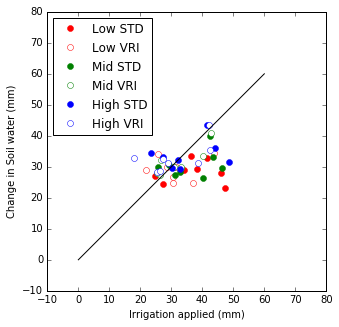

In [18]:
WUDays = ['2017-11-01', '2017-11-08',
 '2017-11-15', '2017-11-22',
 '2017-11-29', '2017-12-06',
 '2017-12-13', '2017-12-20',
 '2017-12-28']
WUTots = ObsPre.dropna(how='any')
CompData = WUTots.ix[WUTots.index.isin(WUDays),:].diff()
Fig = plt.figure(figsize=(5,5))
lineColors = ['r','r','g','g','b','b']
fillColors = ['r','w','g','w','b','w']
pos = 0
for z in Zones:
    for i in Irrigs:
        Obs = CompData.ix[:,('Obs',z,i)]
        Pre = CompData.ix[:,('Pred',z,i)]
        plt.plot(Obs,Pre,'o',
                 mec=lineColors[pos],mfc=fillColors[pos],label=z+' '+i)
        pos+=1
plt.ylim(-10,80)
plt.xlim(-10,80)
plt.plot([0,60],[0,60],'-')
plt.ylabel('Change in Soil water (mm)')
plt.xlabel('Irrigation applied (mm)')
plt.legend(loc=2,numpoints=1)     

### Agreement is pretty good but the Mid VRI treatment water use consistently goes backwards on the day of irrigation suggesting more water was showing up in the profile than what was recoreded as applied irrigation.

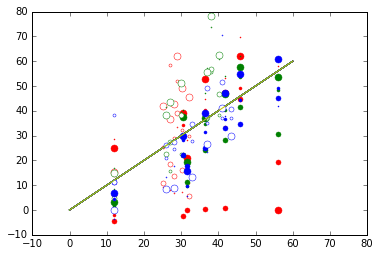

In [19]:
lineColors = ['r','r','g','g','b','b']
fillColors = ['r','w','g','w','b','w']
pos = 0
for z in Zones:
    for i in Irrigs:
        size = 1
        for r in [1,2,3,4]:
            SWincrease = DeltaSWCFrame.ix[WaterUseNP.index.isin(IrrigationsDaysNP),(z,i,r)]*-1
            Applied = Irrigations.ix[Irrigations.index.isin(IrrigationsDaysIR),(z,i)]
            plt.plot(Applied,SWincrease,'o',mec=lineColors[pos],mfc=fillColors[pos],ms=size)
            plt.ylim(-10,80)
            plt.xlim(-10,80)
            plt.plot([0,60],[0,60],'-')
            size +=2
        pos+=1
        

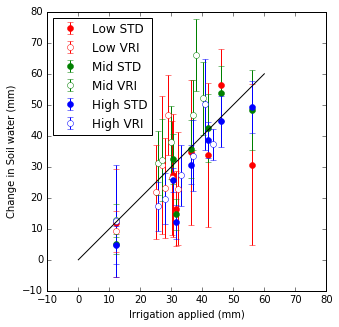

In [20]:
Fig = plt.figure(figsize=(5,5))
lineColors = ['r','r','g','g','b','b']
fillColors = ['r','w','g','w','b','w']
pos = 0
for z in Zones:
    for i in Irrigs:
        SWincrease = DeltaSWCFrame.ix[WaterUseNP.index.isin(IrrigationsDaysNP),(z,i)].mean(axis=1)*-1
        SWincreaseSD = DeltaSWCFrame.ix[WaterUseNP.index.isin(IrrigationsDaysNP),(z,i)].std(axis=1)
        Applied = Irrigations.ix[Irrigations.index.isin(IrrigationsDaysIR),(z,i)]
        plt.errorbar(Applied,SWincrease,SWincreaseSD,fmt='o',
                     mec=lineColors[pos],mfc=fillColors[pos],ecolor=lineColors[pos],label=z+' '+i)
        pos+=1
plt.ylim(-10,80)
plt.xlim(-10,80)
plt.plot([0,60],[0,60],'-')
plt.ylabel('Change in Soil water (mm)')
plt.xlabel('Irrigation applied (mm)')
plt.legend(loc=2,numpoints=1)        

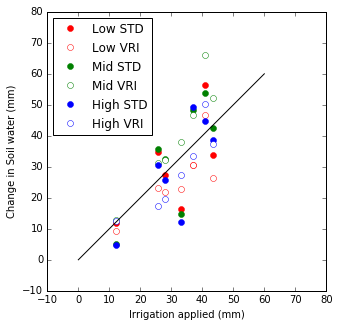

In [21]:
Fig = plt.figure(figsize=(5,5))
lineColors = ['r','r','g','g','b','b']
fillColors = ['r','w','g','w','b','w']
pos = 0
for z in Zones:
    for i in Irrigs:
        SWincrease = DeltaSWCFrame.ix[WaterUseNP.index.isin(IrrigationsDaysNP),(z,i)].mean(axis=1)*-1
        SWincreaseSD = DeltaSWCFrame.ix[WaterUseNP.index.isin(IrrigationsDaysNP),(z,i)].std(axis=1)
        plt.plot(Applied,SWincrease,'o',
                     mec=lineColors[pos],mfc=fillColors[pos],label=z+' '+i)
        pos+=1
plt.ylim(-10,80)
plt.xlim(-10,80)
plt.plot([0,60],[0,60],'-')
plt.ylabel('Change in Soil water (mm)')
plt.xlabel('Irrigation applied (mm)')
plt.legend(loc=2,numpoints=1)        

## Generally good agreement between the increase in soil water content and the amount of water applied but quite noisy.  The Mid VRI treatment is consistently over and all treatments on the biggest irrigation are consistently under.

## Make a dataframe with measured increase in soil water content and use that as or irrigation amount

In [22]:
IrrigationRetained = DeltaSWCFrame.ix[DeltaSWCFrame.index.isin(IrrigationsDaysNP)].copy()*-1+5
IrrigationRetained.index = IrrigationRetained.index - dt.timedelta(1)
IrrigationRetained = IrrigationRetained.ix[Irrigations.index]
IrrigationRetained.fillna(0,inplace=True)

## Recalculate water balance using this irrigaiton

In [23]:
ColIndex = pd.MultiIndex.from_product([('Low','Mid','High'),('STD','VRI'),(1,2,3,4)],names=['Zone','Irrig','Rep'])
WaterUseNPMeasIrr = pd.DataFrame(index = Irrigations.index,
    columns = ColIndex)
WaterUseNPMeasIrr.ix[:,:]=0
DeltaSWCFrame = WaterUseNP.copy() 
for plot in WaterUseNPMeasIrr.columns:
    for P in WaterUseNPMeasIrr.index:
        if P.strftime('%Y-%m-%d') == '2017-10-04':
            PrevPSWC = SoilWaterData.ix[(plot)].ix[P.strftime('%Y-%m-%d'),'ProfileWater'].values[0]
            PrevMeasureDate = '2017-10-04'
        else:
            #print(P.strftime('%Y-%m-%d'))
            DeltaSWC = PrevPSWC - SoilWaterData.ix[(plot)].ix[P.strftime('%Y-%m-%d'),'ProfileWater'].values[0]
            #print(DeltaSWC)
            Irrigation = IrrigationRetained.ix[PrevMeasureDate,plot]
            #print(Irrigation)
            Rainfall = Irrigations.ix[P.strftime('%Y-%m-%d'),('Field','Rain')]
            #print(Rainfall)
            WU = DeltaSWC + Irrigation + Rainfall 
            #print(WU)
            WaterUseNPMeasIrr.ix[P.strftime('%Y-%m-%d'),plot] = WU
            PrevPSWC = SoilWaterData.ix[(plot)].ix[P.strftime('%Y-%m-%d'),'ProfileWater'].values[0]
            PrevMeasureDate = P.strftime('%Y-%m-%d')

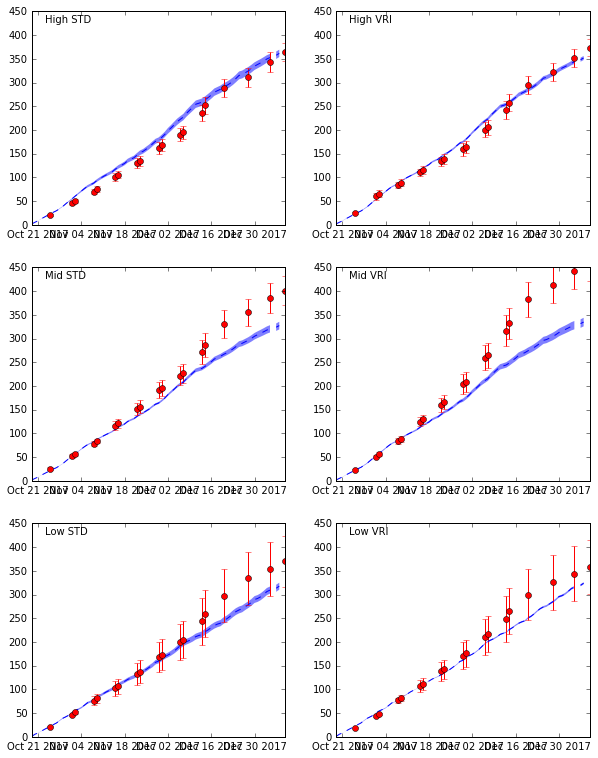

In [24]:
Fig = plt.figure(figsize=(10,13))
pos = 1
for z in ['High','Mid','Low']:
    for i in Irrigs:
        ax = Fig.add_subplot(3,2,pos)
        IRMean = E.ix[:,(z,i)].cumsum().mean(axis=1)
        IRSD = E.ix[:,(z,i)].cumsum().std(axis=1)/2
        IRUp = IRMean + IRSD
        IRLow = IRMean - IRSD
        plt.fill_between(E.index,IRUp,IRLow,alpha=0.5,lw=0)
        plt.plot(IRMean,'--')
        NPMean = WaterUseNPMeasIrr.ix['2017-10-20':,(z,i)].cumsum().mean(axis=1)
        NPSD = WaterUseNPMeasIrr.ix['2017-10-20':,(z,i)].cumsum().std(axis=1)/2
        NPUp = NPMean + NPSD
        NPLow = NPMean - NPSD
        plt.errorbar(WaterUseNPMeasIrr.ix['2017-10-20':,(z,i)].index,NPMean,NPSD,fmt='o',color='r')
        #plt.plot(NPMean,'o',color='r')
        plt.text(0.05,0.95,z+' ' +i,transform = ax.transAxes)
        pos += 1
        plt.ylim(0,450)